In [3]:
import pydicom
import os,re
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from pydicom.dataset import Dataset, FileDataset
import tempfile
import SimpleITK as sitk
import math
from ipywidgets import interact, fixed
from skimage.transform import resize
from IPython.display import clear_output
from scipy.ndimage import zoom
import scipy.misc
from sys import platform
import shutil
platform

'win32'

In [4]:
p=512
ESP=0.1

def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    # img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z]
    fixed = sitk.GetArrayFromImage(fixed)
    moving = sitk.GetArrayFromImage(moving)
    dst = cv2.addWeighted(fixed[image_z,:,:],1.0-alpha,moving[image_z,:,:],alpha,0)
    plt.imshow(dst, cmap=plt.cm.Greys_r)
    # plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

def save_transform_and_image(transform, fixed_image, moving_image, fixed_ori,moving_ori, dicompath, outputfile_prefix,multi_tp):
                           
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.     
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(transform)
    #sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix+'.mha')
    #sitk.WriteTransform(transform, outputfile_prefix+'.tfm')
    max_moving = 0
    exqimg = sitk.GetArrayFromImage(resample.Execute(moving_image))
    for i in range(0,exqimg.shape[2]):
        max_moving = max(max_moving,np.amax(exqimg[:,:,i]))
    
    if multi_tp == False:

        ds_ori = pydicom.dcmread(fixed_ori[0])
        ds_ori_end = pydicom.dcmread(fixed_ori[-1])
        sp_x = (ds_ori_end[0x20,0x32].value[0]-ds_ori[0x20,0x32].value[0])/len(fixed_ori)
        sp_y = (ds_ori_end[0x20,0x32].value[1]-ds_ori[0x20,0x32].value[1])/len(fixed_ori)
        sp_z = (ds_ori_end[0x20,0x32].value[2]-ds_ori[0x20,0x32].value[2])/len(fixed_ori)
        a =  abs(float(ds_ori[0x20,0x32].value[0])-float(ds_ori_end[0x20,0x32].value[0]))
        b =  abs(float(ds_ori[0x20,0x32].value[1])-float(ds_ori_end[0x20,0x32].value[1]))
        c =  abs(float(ds_ori[0x20,0x32].value[2])-float(ds_ori_end[0x20,0x32].value[2]))
        spori = -math.sqrt(sp_x*sp_x+sp_y*sp_y+sp_z*sp_z)
        slicelocation_axis = 'x'
        if min(a,b,c)==b:
            slicelocation_axis = 'y'
        elif min(a,b,c)==c:
            slicelocation_axis = 'z'


        if len(moving_ori)<len(fixed_ori):
            reg_img = resample.Execute(moving_image)
            #reg_img_resample = zoom(reg_img, (1, 1, len(moving_ori)/len(fixed_ori)))

            new_x_size = (reg_img.GetSize())[0] 
            new_y_size = (reg_img.GetSize())[1]
            new_z_size = len(moving_ori) #downsample
            new_size = [new_x_size, new_y_size, new_z_size]
            new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(reg_img.GetSize(), reg_img.GetSpacing(), new_size)]
            interpolator_type = sitk.sitkLinear

            reg_img_resample = sitk.Resample(reg_img, new_size, sitk.Transform(),\
                                             interpolator_type, reg_img.GetOrigin(),\
                                             new_spacing, reg_img.GetDirection(), 0.0, reg_img.GetPixelIDValue())
            
            #new_reg_img_resample = (reg_img_resample-0)/(max_moving-0)*p
            new_reg_img_resample = reg_img_resample
            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path) 
                #new_data = ds.pixel_array
                new_data = sitk.GetArrayFromImage(new_reg_img_resample[:,:,i])
                #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                #new_data[new_data<0]=0
                #new_data[new_data>p]=p
                new_data = (new_data).astype('uint16')
                sp = -(spori)*(len(fixed_ori)/len(moving_ori))
                xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                #print((float(ds_ori[0x18,0x88].value)),len(fixed_ori),len(moving_ori),sp)
                ds[0x18,0x88].value = sp

                ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                '''
                if slicelocation_axis == 'x':
                    ds.SliceLocation = ds_ori.SliceLocation+xsp*i
                elif slicelocation_axis == 'y':
                    ds.SliceLocation = ds_ori.SliceLocation+ysp*i
                elif slicelocation_axis == 'z':
                    ds.SliceLocation = ds_ori.SliceLocation+zsp*i
                '''
                orientation = [ds_ori[0x20,0x32].value[0]+xsp*i,\
                                ds_ori[0x20,0x32].value[1]+ysp*i,ds_ori[0x20,0x32].value[2]+zsp*i]
                ds[0x20,0x32].value =  orientation
                ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                ds.PixelData = new_data.tostring()
                newpath = dicompath+ tail
                ds.save_as(newpath)
                print(newpath)

        elif len(moving_ori)>=len(fixed_ori):    
            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path)
                reg_img = resample.Execute(moving_image)
                
                #new_reg_img = (reg_img-0)/(max_moving-0)*p
                new_reg_img = reg_img
                if i < len(fixed_ori):
                    ds_ori = pydicom.dcmread(fixed_ori[i])
                    #new_data = ds.pixel_array
                    new_data = sitk.GetArrayFromImage(new_reg_img[:,:,i])
                    #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                    #new_data[new_data<0]=0
                    #new_data[new_data>p]=p
                    new_data = (new_data).astype('uint16')
                    ds[0x20,0x32].value = ds_ori[0x20,0x32].value
                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    #ds.SliceLocation = ds_ori.SliceLocation
                    ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                    ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)
                else:
                    ds_ori = pydicom.dcmread(fixed_ori[-1])
                    new_data = np.zeros((ds_ori.Rows,ds_ori.Columns))            
                    new_data = (new_data).astype('uint16')
                   # sp = -(float(ds_ori[0x18,0x88].value))
                    xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                    ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                    zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                    orientation = [ds_ori[0x20,0x32].value[0]+xsp*(i-len(fixed_ori)),\
                                   ds_ori[0x20,0x32].value[1]+ysp*(i-len(fixed_ori))\
                                   ,ds_ori[0x20,0x32].value[2]+zsp*(i-len(fixed_ori))]
                    ds[0x20,0x32].value =  orientation


                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    '''
                    if slicelocation_axis == 'x':
                        ds.SliceLocation = ds_ori.SliceLocation+xsp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'y':
                        ds.SliceLocation = ds_ori.SliceLocation+ysp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'z':
                        ds.SliceLocation = ds_ori.SliceLocation+zsp*(i-len(fixed_ori))
                    '''
                    #ds.SliceLocation = ds_ori.SliceLocation+sp*(i-len(fixed_ori))
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.Rows = ds_ori.Rows
                    ds.Columns = ds_ori.Columns
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)


           # ds = pydicom.dcmread(newpath)
           # img = ds.pixel_array
           # plt.figure()
           # plt.imshow(img)
           # plt.show()
           # plt.close()
    else:
        reg_img = resample.Execute(moving_image)
        new_reg_img = reg_img
        #new_reg_img = (reg_img-0)/(max_moving-0)*p
        for i in range(0,len(moving_ori)): 
            path = moving_ori[i]
            ds = pydicom.dcmread(path)
            head,tail = os.path.split(path)
            ds_ori = pydicom.dcmread(fixed_ori[i])
            #new_data = ds.pixel_array
            new_data = sitk.GetArrayFromImage((new_reg_img)[:,:,i])
            #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
            #new_data[new_data<0]=0
            #new_data[new_data>p]=p
            new_data = (new_data).astype('uint16')
            ds[0x20,0x32].value = ds_ori[0x20,0x32].value
            ds[0x20,0x37].value = ds_ori[0x20,0x37].value
            #ds.SliceLocation = ds_ori.SliceLocation
            ds[0x28,0x10].value = ds_ori[0x28,0x10].value
            ds[0x28,0x11].value = ds_ori[0x28,0x11].value
            ds[0x28,0x30].value = ds_ori[0x28,0x30].value
            ds.PixelData = new_data.tostring()
            newpath = dicompath+ tail
            ds.save_as(newpath)
            print(newpath)

from IPython.display import clear_output

# Callback we associate with the StartEvent, sets up our new data.
def metric_start_plot():
    global metric_values, multires_iterations
    global current_iteration_number
    
    metric_values = []
    multires_iterations = []
    current_iteration_number = -1

# Callback we associate with the EndEvent, do cleanup of data and figure.
def metric_end_plot():
    global metric_values, multires_iterations
    global current_iteration_number

    del metric_values
    del multires_iterations
    del current_iteration_number
    # Close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

# Callback we associate with the IterationEvent, update our data and display 
# new figure.    
def metric_plot_values(registration_method):
    global metric_values, multires_iterations
    global current_iteration_number
    
    # Some optimizers report an iteration event for function evaluations and not
    # a complete iteration, we only want to update every iteration.
    if registration_method.GetOptimizerIteration() == current_iteration_number:
        return
    
    current_iteration_number =  registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot 
    # current data.
    clear_output(wait=True)
    # Plot the similarity metric values.
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback we associate with the MultiResolutionIterationEvent, update the 
# index into the metric_values list. 
def metric_update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))  

In [23]:
import importlib
import sys
sys.path.append(r'..\FRAPPE')
import DB
importlib.reload(DB)
from DB import DB

TPS = ['0','12','18','24','30','36','48','60','72','84','96']

def getdcmpath(pid,TPid,side='L'):
    #following TPs
    VFVersion = '29'
    paths = []
    if TPid not in [0,1,2,3,4,5,6,8,10]:
        print('not valid TP')
        return 
        
    dbconfig = {}
    dbconfig['dbname'] = 'ahaknee'+TPS[TPid]+'tp'+VFVersion
    dbconfig['host']="128.208.221.46"#Server #4
    dbconfig['user']="root"
    dbconfig['passwd']="123456"
    db = DB(config=dbconfig)

    db.getcursor()
    sql = '''\
    SELECT
    pid,eid,dicompath
    FROM
    stat
    where pid = %s
    '''
    db.mycursor.execute(sql,[pid])
    dbr = db.mycursor.fetchall() 
    for di in dbr:
        if di[1][-1]==side:
            tmp = di[2]
            return 'Y' + tmp[1:]
    return

In [24]:
# process list
# first in TP as reference
caselist = [
    {'pid': '9404954','TP':[0,1,2,3,4,5,6,8,10],'side':'L'}
]
    
icafepath = r'Z:\iCafe\result\OAIMTP/'

split_seq_path = 'split_seq_OAI/'

if not os.path.exists(split_seq_path):
    os.mkdir(split_seq_path)

In [25]:
getdcmpath('9911265',0,'L'),getdcmpath('9911265',1,'R'),getdcmpath('9911265',8,'R')

ahaknee0tp29  exist
ahaknee12tp29  exist
ahaknee72tp29  exist


('Y:/OAI Baseline/ge0/9911265/10767108',
 'Y:/OAI 12 Months/2.C.2/9911265/20060512/11146712',
 'Y:/OAI 72 Months/8.E.1/9911265/20110418/12968511')

In [26]:
#split seqs for a case
    
for casei in caselist:
    pi = casei['pid']
    side = casei['side']
    
    precasepath = split_seq_path + pi + side + '/'
    if not os.path.exists(precasepath):
        os.mkdir(precasepath)
        
    regtp = casei['TP']
    
    for tpi in regtp:
        casepath = getdcmpath(pi, tpi, side)
            
        if casepath is None:
            print('cannot find dcm path for TPid',tpi)
            continue
        else:
            print('dcm path for TPid', tpi, casepath)
            
            tp_precasepath = precasepath + 'TP' + str(tpi) + '/'
            if not os.path.exists(tp_precasepath):
                os.mkdir(tp_precasepath)
                
            filelist = os.listdir(casepath)
            for f in filelist:
                if ('.dcm') not in f:
                    del filelist[filelist.index(f)]
    
            for f in filelist:
                src = casepath + '/' + f
                print('\rcopying', src, end='')
                for attempt in range(20):
                    try:
                        dst = tp_precasepath + f
                        if not os.path.exists(dst):
                            shutil.copyfile(src, dst)
                            
                    except:
                        print('@@@@Connection loss. Retry!@@@@')
                        continue
                    break
                else:
                    print('###Tried 20 times, still failed')

ahaknee0tp29  exist
dcm path for TPid 0 Y:/OAI Baseline/gc0/9404954/10728107
copying Y:/OAI Baseline/gc0/9404954/10728107/076.dcmahaknee12tp29  exist
dcm path for TPid 1 Y:/OAI 12 Months/1.C.2/9404954/20060223/10862205
copying Y:/OAI 12 Months/1.C.2/9404954/20060223/10862205/076.dcmahaknee18tp29  exist
cannot find dcm path for TPid 2
ahaknee24tp29  exist


dcm path for TPid 3 Y:/OAI 24 Months/3.C.2/9404954/20070518/11732407
copying Y:/OAI 24 Months/3.C.2/9404954/20070518/11732407/076.dcm Y:/OAI 24 Months/3.C.2/9404954/20070518/11732407/055.dcmahaknee30tp29  exist
cannot find dcm path for TPid 4
ahaknee36tp29  exist
cannot find dcm path for TPid 5
ahaknee48tp29  exist
dcm path for TPid 6 Y:/OAI 48 Months/6.C.1/9404954/20090323/12540108
copying Y:/OAI 48 Months/6.C.1/9404954/20090323/12540108/076.dcmY:/OAI 48 Months/6.C.1/9404954/20090323/12540108/035.dcm Y:/OAI 48 Months/6.C.1/9404954/20090323/12540108/045.dcmahaknee72tp29  exist
dcm path for TPid 8 Y:/OAI 72 Months/8.C.1/9404954/20110202/13000504
copying Y:/OAI 72 Months/8.C.1/9404954/20110202/13000504/076.dcmahaknee96tp29  existC.1/9404954/20110202/13000504/036.dcm
dcm path for TPid 10 Y:/OAI 96 Months/10.C.1/9404954/20121119/13579209
copying Y:/OAI 96 Months/10.C.1/9404954/20121119/13579209/076.dcm Y:/OAI 96 Months/10.C.1/9404954/20121119/13579209/032.dcm

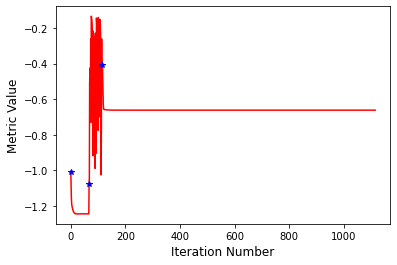

Final metric value: -0.6619272731755612
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (1000) exceeded.
itk::simple::Transform
 CompositeTransform (000001FC4BDF10D0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 2845336
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (000001FC782DE5D0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 2845327
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.998504 -0.0532172 -0.0125229 
       0.053269 0.998573 0.00384059 
       0.0123006 -0.00450192 0.999914 
     Offset: [0.0568352, -5.69512, -7.28771]
     Center: [75.0121, -0.182292, 7.25514]
     Translation: [-0.136504, -1.67117, -6.36482]
     Inverse: 
       0.998504 0.053269 0.0123006 
       -0.0532172 0.998573 -0.004

In [27]:
for casei in caselist:
    pi = casei['pid']
    side = casei['side']
    
    precasepath = split_seq_path + pi + side + '/'
        
    regtp = casei['TP']
    if len(regtp) < 2:
        print(pi, 'not enough TPs')
        continue
    
    tp1 = regtp[0]
    tp1_casepath = precasepath + 'TP0/'
            
    icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
    if not os.path.exists(icafesavepath):
        print('Init icafe dir')
        os.mkdir(icafesavepath)
        
    TP1path = []
    flist = os.listdir(tp1_casepath)
    
    for f in flist:
        dicomfilename = tp1_casepath + f
        dcmimgcr = pydicom.dcmread(dicomfilename)
        if abs(float(dcmimgcr.ImageOrientationPatient[0]))<abs(float(dcmimgcr.ImageOrientationPatient[1])):
            #coronal slice showing scan areas
            print('coronal',dicomfilename)
            os.remove(dicomfilename)
        else:
            TP1path.append(dicomfilename)
            
    fixed_image = sitk.ReadImage(TP1path)
    
    isoresample = sitk.ResampleImageFilter()
    isoresample.SetInterpolator(sitk.sitkBSpline)
    isoresample.SetOutputDirection(fixed_image.GetDirection())
    isoresample.SetOutputOrigin(fixed_image.GetOrigin())
    orig_spacing = fixed_image.GetSpacing()
    new_spacing = (orig_spacing[0],orig_spacing[0],orig_spacing[0])
    isoresample.SetOutputSpacing(new_spacing)
    orig_size = np.array(fixed_image.GetSize(), dtype=np.int)    
    new_size = orig_size.copy()
    new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
    new_size = [int(s) for s in new_size]
    print(orig_size, new_size)
    isoresample.SetSize(new_size)
    
    fixed_image = isoresample.Execute(fixed_image)
    sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_US100.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_US100.tif')
    
    for tp2 in regtp[1:2]:
        #if tp2 != 1: continue
            
        tp2_casepath = getdcmpath(pi,tp2,side) 
        if tp2_casepath is None:
            print('cannot find dcm path for TPid', tp2)
            continue
        
        tp2_casepath = precasepath + 'TP' + str(tp2) + '/'

        TP2path = []
        
        flist = os.listdir(tp2_casepath)
        for f in flist:
            dicomfilename = tp2_casepath+f
            dcmimgcr = pydicom.dcmread(dicomfilename)
            if abs(float(dcmimgcr.ImageOrientationPatient[0]))<abs(float(dcmimgcr.ImageOrientationPatient[1])):
                #coronal slice showing scan areas
                print('coronal', dicomfilename)
                # os.remove(dicomfilename)
            else:
                TP2path.append(dicomfilename)
        
        reader = sitk.ImageSeriesReader()
        print("reading image......", pi + 'TP' + str(tp2))
        moving_image = sitk.ReadImage(TP2path)
        
        initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                              moving_image, 
                                                              sitk.Euler3DTransform(), 
                                                              sitk.CenteredTransformInitializerFilter.GEOMETRY)
        
        # rigid registration
        registration_method = sitk.ImageRegistrationMethod()

        # Similarity metric settings.
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=500)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.01)
        
        registration_method.SetInterpolator(sitk.sitkLinear)
        
        # Optimizer settings.
        registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-10, convergenceWindowSize=50)
        registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        # Don't optimize in-place, we would possibly like to run this cell multiple times.
        registration_method.SetInitialTransform(initial_transform, inPlace=False)

        # Connect all of the observers so that we can perform plotting during registration.
        registration_method.AddCommand(sitk.sitkStartEvent,metric_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent,metric_end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                       metric_update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                       lambda: metric_plot_values(registration_method))

        final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                      sitk.Cast(moving_image, sitk.sitkFloat32))
        
        print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
        print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
        
        print(final_transform)
        
       

In [28]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=154, description='image_z', max=308), FloatSlider(value=0.5, description…

In [27]:
# FFD transform(Free Form Deformation)
def bspline_intra_modal_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    
    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

def generate_random_pointset(image, image2, num_points):
    """
    Generate a random set (uniform sample) of points in the given image's domain.
    
    Args:
        image (SimpleITK.Image): Domain in which points are created.
        num_points (int): Number of points to generate.
        
    Returns:
        A list of points (tuples).
    """
    # Continous random uniform point indexes inside the image bounds.
    point_indexes = np.multiply(np.tile(image.GetSize(), (num_points, 1)), 
                                np.random.random((num_points, image.GetDimension())))
    pointset_list = point_indexes.tolist()
    # Get the list of physical points corresponding to the indexes.
    return [image.TransformContinuousIndexToPhysicalPoint(point_index) \
            for point_index in pointset_list], [image2.TransformContinuousIndexToPhysicalPoint(point_index) \
            for point_index in pointset_list]

In [41]:
for casei in caselist:
    pi = casei['pid']
    side = casei['side']
    
    precasepath = split_seq_path + pi + side + '/'
        
    regtp = casei['TP']
    if len(regtp) < 2:
        print(pi, 'not enough TPs')
        continue
    
    tp1 = regtp[0]
    tp1_casepath = precasepath + 'TP0/'
            
    icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
    if not os.path.exists(icafesavepath):
        print('Init icafe dir')
        os.mkdir(icafesavepath)
        
    TP1path = []
    flist = os.listdir(tp1_casepath)
    
    for f in flist:
        dicomfilename = tp1_casepath + f
        dcmimgcr = pydicom.dcmread(dicomfilename)
        if abs(float(dcmimgcr.ImageOrientationPatient[0]))<abs(float(dcmimgcr.ImageOrientationPatient[1])):
            #coronal slice showing scan areas
            print('coronal',dicomfilename)
            os.remove(dicomfilename)
        else:
            TP1path.append(dicomfilename)
            
    fixed_image = sitk.ReadImage(TP1path)
    
    # isotropic resolution
    isoresample = sitk.ResampleImageFilter()
    isoresample.SetInterpolator(sitk.sitkBSpline)
    isoresample.SetOutputDirection(fixed_image.GetDirection())
    isoresample.SetOutputOrigin(fixed_image.GetOrigin())
    orig_spacing = fixed_image.GetSpacing()
    new_spacing = (orig_spacing[0],orig_spacing[0],orig_spacing[0])
    isoresample.SetOutputSpacing(new_spacing)
    orig_size = np.array(fixed_image.GetSize(), dtype=np.int)    
    new_size = orig_size.copy()
    new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
    new_size = [int(s) for s in new_size]
    print(orig_size, new_size)
    isoresample.SetSize(new_size)
    
    fixed_image = isoresample.Execute(fixed_image)
    sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_US100.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_US100.tif')
    
    for tp2 in regtp[1:]:
        #if tp2 != 1: continue
            
        tp2_casepath = getdcmpath(pi,tp2,side) 
        if tp2_casepath is None:
            print('cannot find dcm path for TPid', tp2)
            continue
        
        tp2_casepath = precasepath + 'TP' + str(tp2) + '/'

        TP2path = []
        
        flist = os.listdir(tp2_casepath)
        for f in flist:
            dicomfilename = tp2_casepath+f
            dcmimgcr = pydicom.dcmread(dicomfilename)
            if abs(float(dcmimgcr.ImageOrientationPatient[0]))<abs(float(dcmimgcr.ImageOrientationPatient[1])):
                #coronal slice showing scan areas
                print('coronal', dicomfilename)
                # os.remove(dicomfilename)
            else:
                TP2path.append(dicomfilename)
        
        reader = sitk.ImageSeriesReader()
        print("reading image......", pi + 'TP' + str(tp2))
        moving_image = sitk.ReadImage(TP2path)
        
        fixed_points, moving_points = generate_random_pointset(fixed_image, moving_image, 50)
        ffd_transform = bspline_intra_modal_registration(fixed_image = fixed_image, 
                                                         moving_image = moving_image,
#                                     fixed_points=fixed_points, 
#                                     moving_points=moving_points
                                    )
# 上面取消注释会报错module 'SimpleITK' has no attribute 'CompositeTransform'，但文档里c++版本是有这个类的
        #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
        #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
        
        #print(ffd_transform)
        exqimg = sitk.Resample(moving_image, fixed_image, ffd_transform, sitk.sitkBSpline, 0.0, moving_image.GetPixelID())
        
        if tp2==10:
            SEQ = 'S109'
        else:
            SEQ = 'S10'+str(tp2)
        sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_U' + SEQ + '.tif')
        print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U' + SEQ + '.tif')


[384 384  75] [384, 384, 309]
save to icafe path D:\iCafe\result\OAIMTP/0_P9404954R_U/TH_0_P9404954R_U.tif
save to icafe path D:\iCafe\result\OAIMTP/0_P9404954R_U/TH_0_P9404954R_US100.tif
ahaknee12tp29  exist
coronal split_seq_OAI/9404954R/TP1/001.dcm
reading image...... 9404954TP1
Final metric value: 417.68280532659725
Optimizer's stopping condition, LBFGSBOptimizerv4: Function tolerance reached after 60 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
save to icafe path D:\iCafe\result\OAIMTP/0_P9404954R_U/TH_0_P9404954R_US101.tif
ahaknee18tp29  exist
cannot find dcm path for TPid 2
ahaknee24tp29  exist
coronal split_seq_OAI/9404954R/TP3/076.dcm
reading image...... 9404954TP3
Final metric value: 1755.681177331056
Optimizer's stopping condition, LBFGSBOptimizerv4: Function tolerance reached after 37 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConver

In [38]:
moving_resampled = sitk.Resample(moving_image, fixed_image, ffd_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…